## Settings

In [274]:
import io
from typing import Any, Dict, List, OrderedDict, Union
import os
from os.path import join as osj
import cv2
import decord
import matplotlib
import matplotlib.pyplot as plt
import moviepy.editor as mpy
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib.collections import LineCollection
import random
import pandas as pd
from workoutdetector.datasets import FrameDataset, build_test_transform, RepcountHelper
from workoutdetector.utils import plot_all, plt_params, plot_per_action
from matplotlib import font_manager
import json

matplotlib.RcParams.update(plt_params())
font_path = '/mnt/c/Users/Me/AppData/Local/Microsoft/Windows/Fonts/Cairo-VariableFont_wght.ttf'
font_manager.fontManager.addfont(font_path)
font_manager.findSystemFonts(fontext='otf')
fe = font_manager.FontEntry(fname=font_path, name='Cairo')
font_manager.fontManager.ttflist.insert(0, fe) 
matplotlib.rcParams.update(plt_params())
matplotlib.rcParams['font.family'] = 'Cairo'

CLASSES = ['situp', 'push_up', 'pull_up', 'jump_jack', 'squat', 'front_raise']

COLORS = list(plt.get_cmap('tab20').colors)

params = {
    'figure.dpi': 300,
    'figure.figsize': (8, 5),
    'figure.autolayout': True,
    'lines.linewidth': 0.8,
    'axes.prop_cycle': plt.cycler('color', COLORS),
    'font.size': 8,
    'font.family': 'Cairo',
}


In [2]:
data_root = os.path.expanduser("~/data/RepCount")
anno_path = osj(data_root, "annotation.csv")
helper = RepcountHelper(data_root, anno_path)
CLASSES = helper.classes
print(CLASSES)
data = list(helper.get_rep_data(['train', 'val', 'test'], ['all']).values())
item = random.choice(data)
print(item)

['situp', 'push_up', 'pull_up', 'jump_jack', 'squat', 'front_raise']
video: stu7_43.mp4
class: pull_up
count: 23
reps: [88, 130, 130, 160, 160, 189, 189, 219, 219, 246, 247, 281, 282, 313, 313, 345, 345, 379, 379, 412, 412, 444, 445, 474, 474, 511, 511, 548, 549, 585, 585, 621, 622, 658, 658, 693, 693, 737, 737, 780, 781, 832, 832, 900, 900, 1013]
fps: 30.0


In [3]:
json_dir = os.path.expanduser('~/projects/WorkoutDetector/out/acc_0.841_epoch_26_20220711-191616_1x1')
json_files = os.listdir(json_dir)
template  = '{}.stride_1_step_1.json'
print(len(json_files))
print(json_files[0])
print(json.load(open(osj(json_dir, json_files[0]))).keys())

762
stu7_51.mp4.stride_1_step_1.json
dict_keys(['video_name', 'model', 'stride', 'step', 'length', 'fps', 'input_shape', 'checkpoint', 'total_frames', 'ground_truth', 'action', 'scores'])


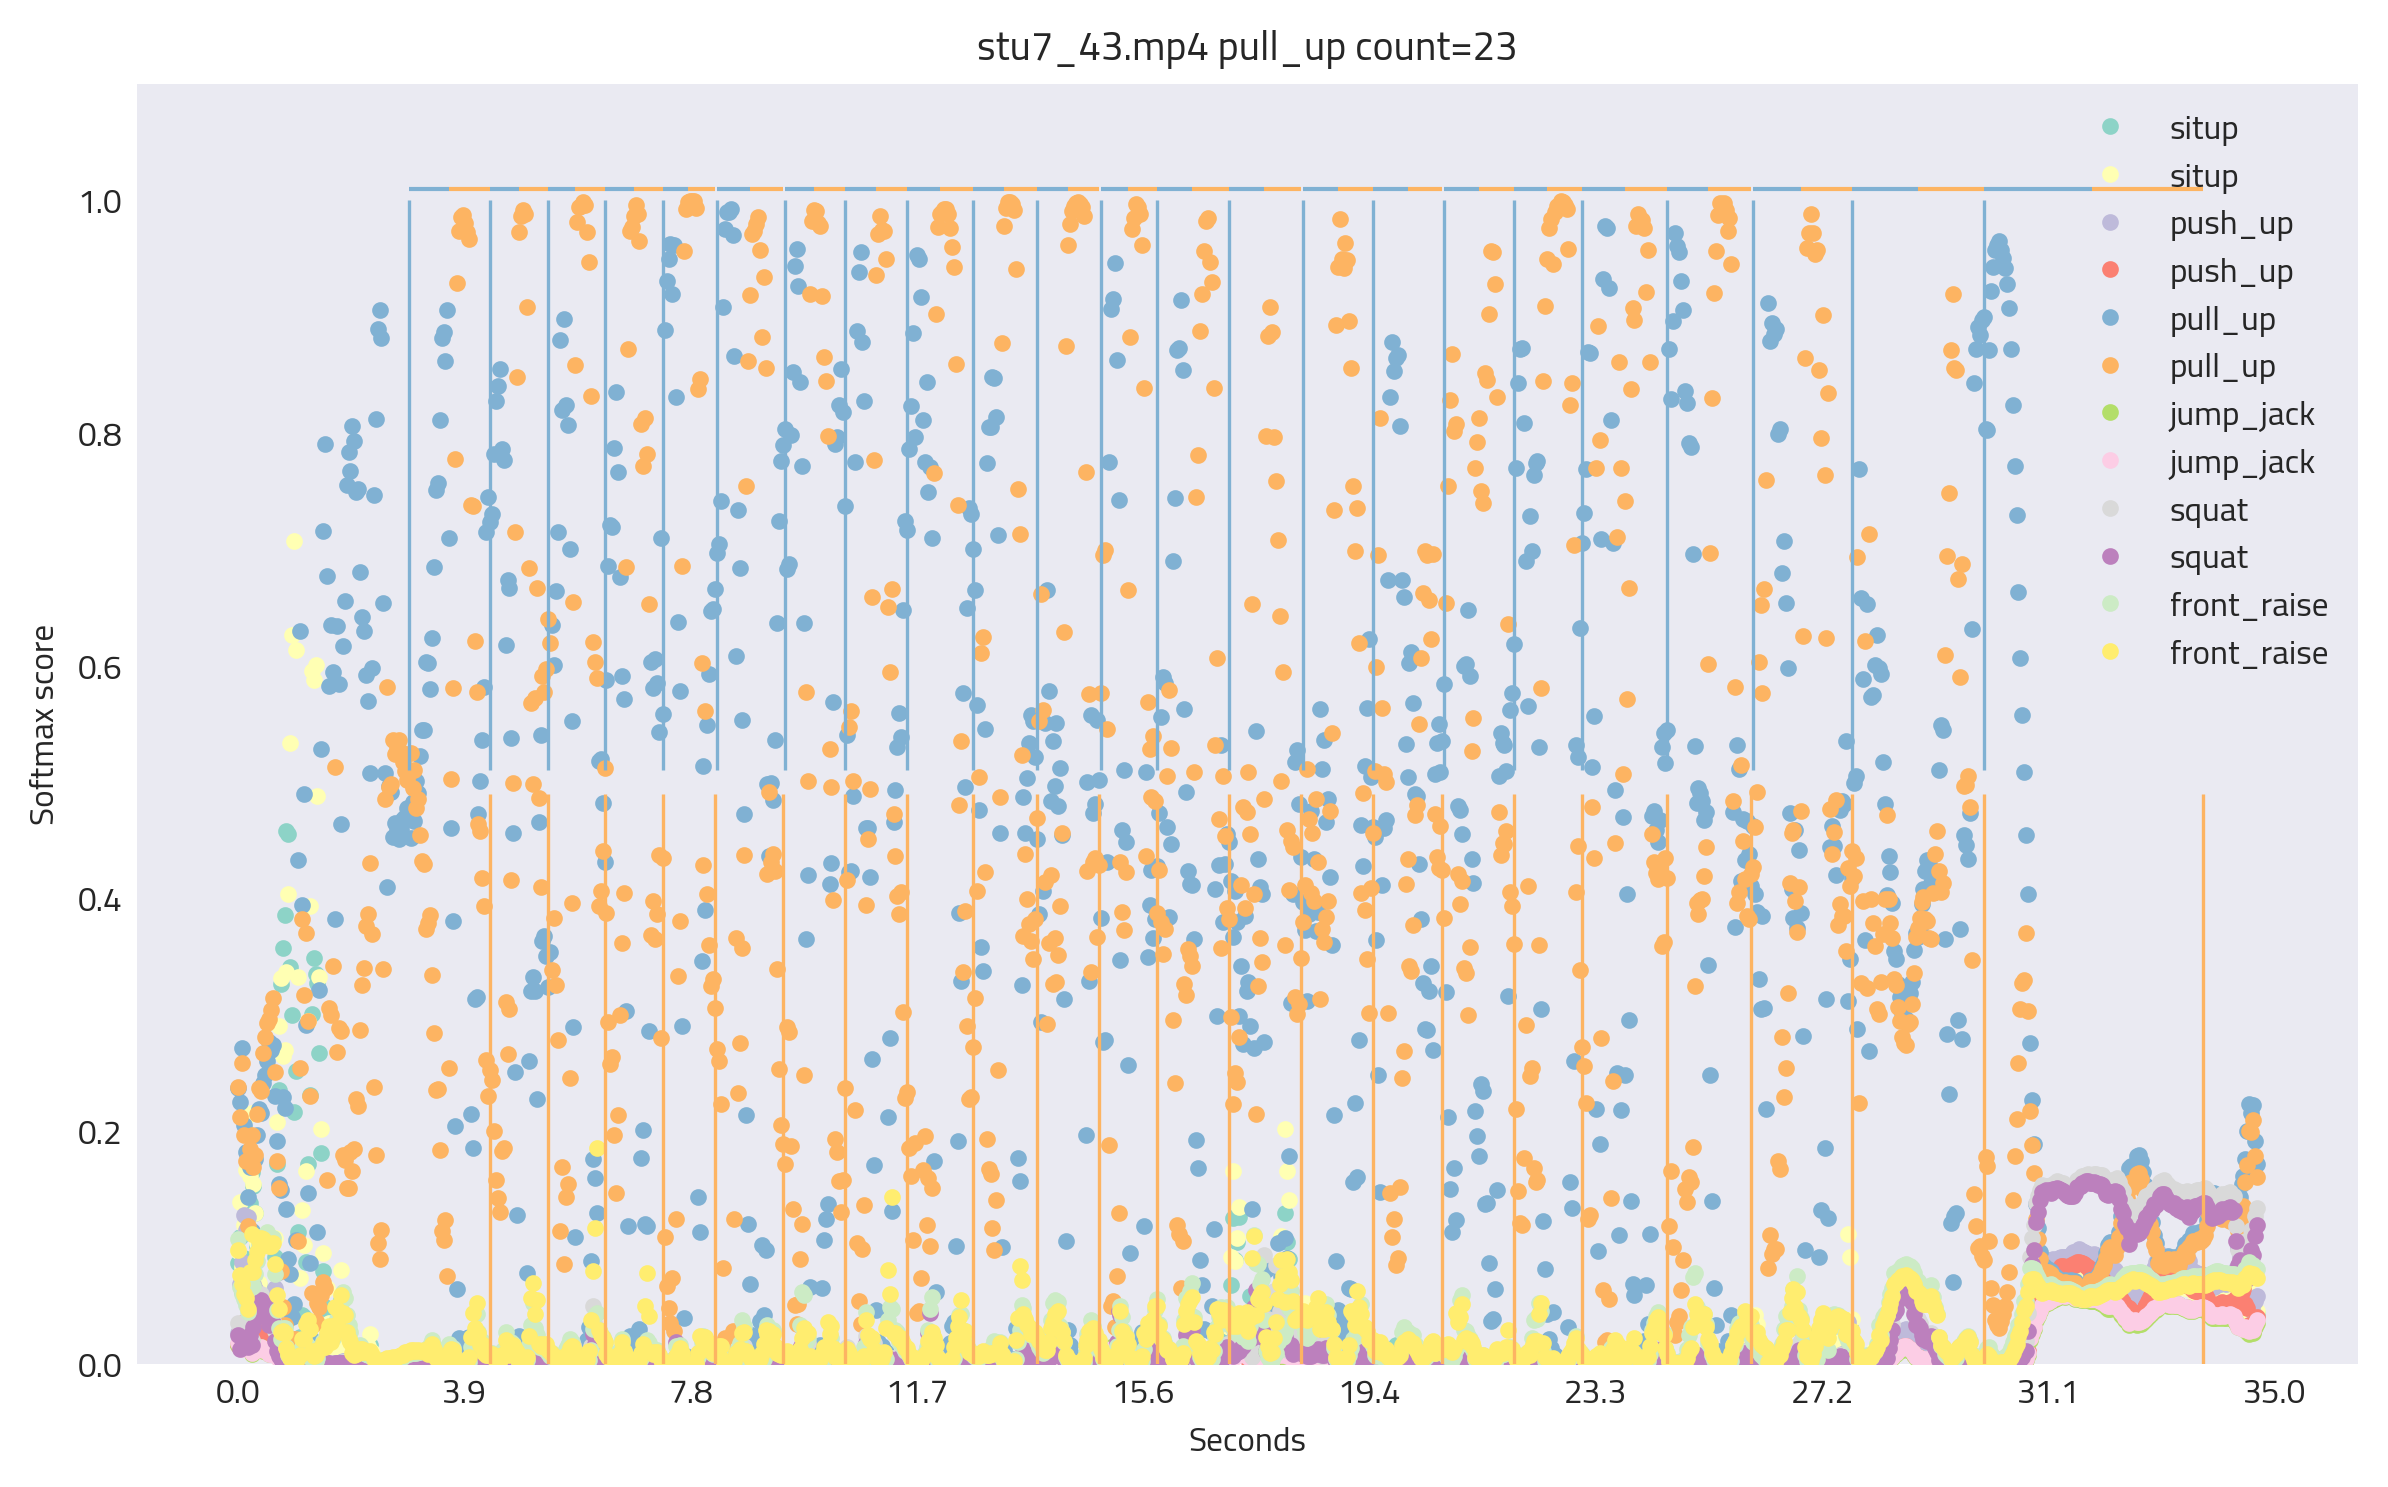

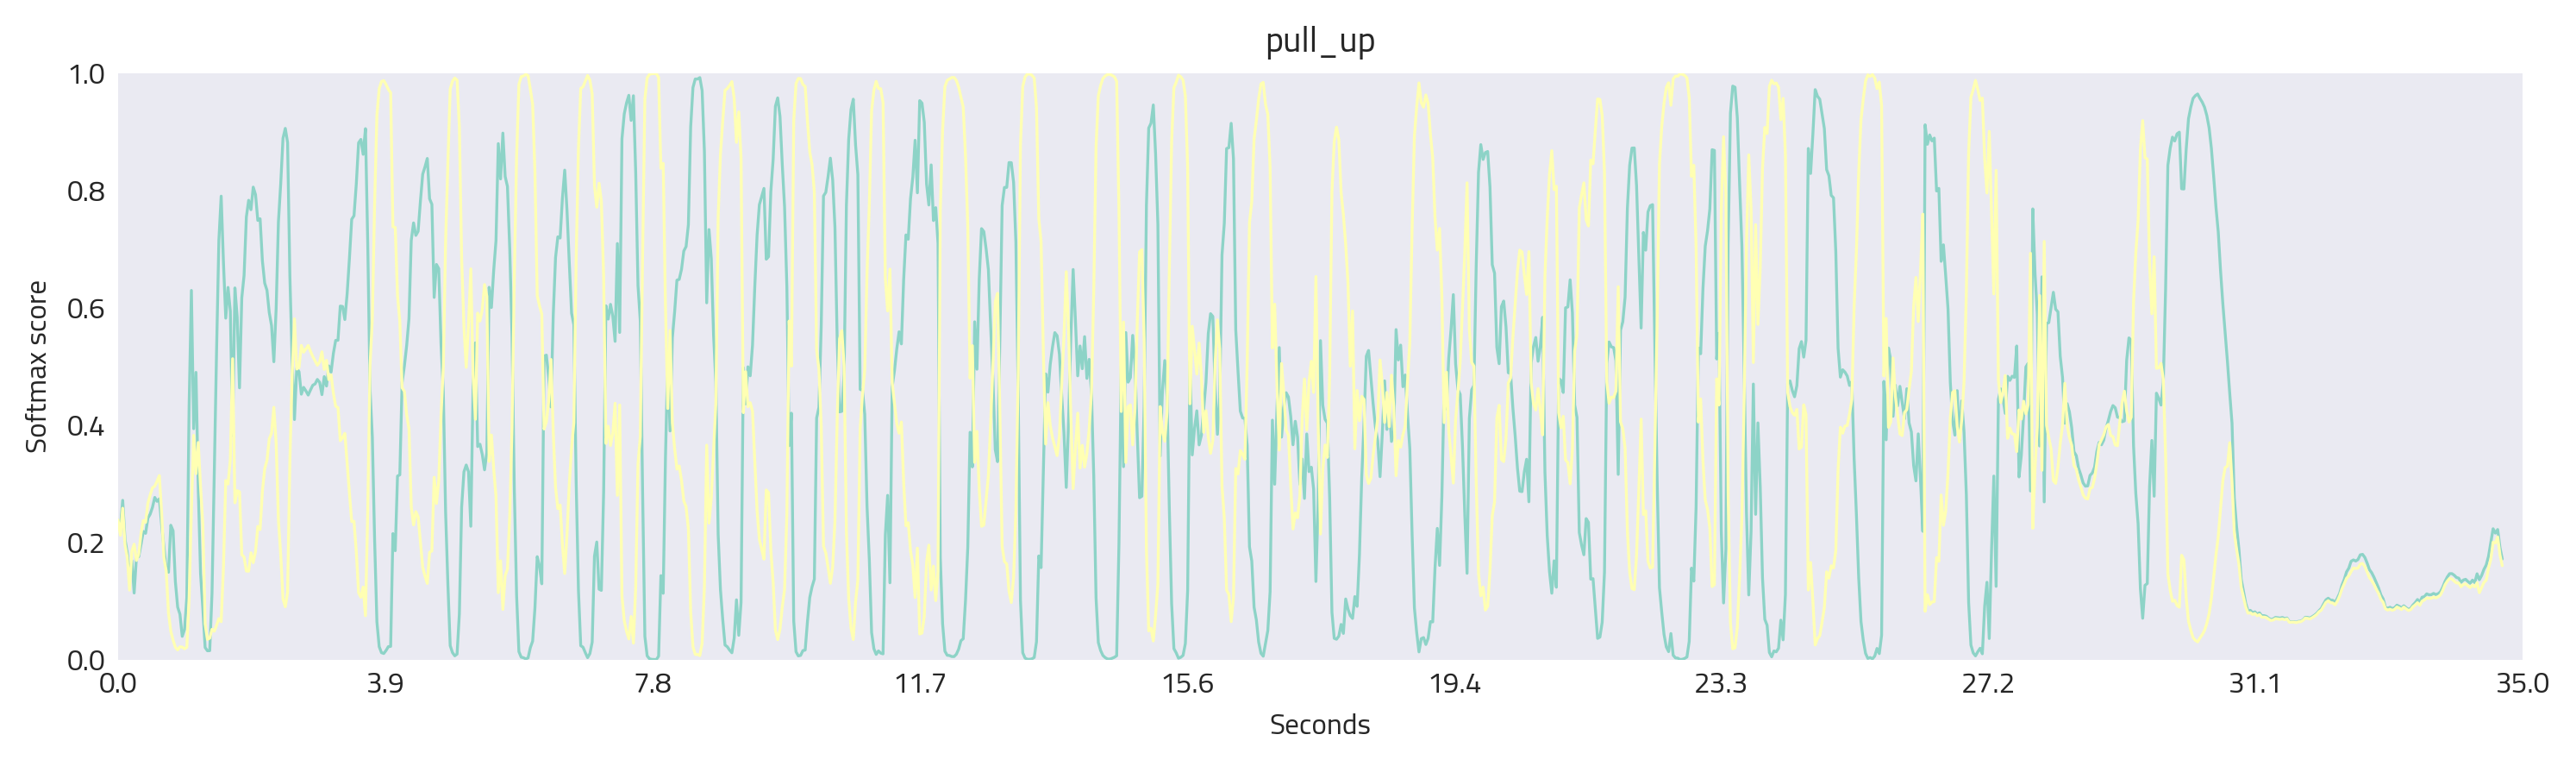

In [4]:
js = json.load(open(osj(json_dir, template.format(item.video_name))))

plot_all(js['ground_truth'], js, softmax=True, stride=1)
plot_per_action(js, softmax=True, action_only=True)

## Hidden Markov Model

- Input: a sequence of probabilities of shape (seq_len, 12)
- Output: a integer state

In [5]:
from hmmlearn import hmm
from workoutdetector.datasets import FeatureDataset
from workoutdetector.utils import pred_to_count
from workoutdetector.time_series import reps_to_label
from torch.utils.data import DataLoader

In [267]:
def train(action):
    feat_ds = FeatureDataset(json_dir, anno_path, 'train',action=action, window=1, stride=1)
    print(action, feat_ds.x.shape, 'num y', np.unique(feat_ds.y))
    # softmax_x = F.softmax(torch.from_numpy(feat_ds.x), dim=1).numpy()
    transmat, pi, means, cov = feat_ds.hmm_stats(feat_ds.x, feat_ds.y)
    # print(transmat, pi, means, cov)
    model = hmm.GaussianHMM(n_components=3, n_iter=300, covariance_type='diag')
    model.transmat_ = transmat
    model.startprob_ = pi.T
    model.means_ = means
    model.covars_ = cov
    softmax_x = F.softmax(torch.from_numpy(feat_ds.x.squeeze(1)), dim=1)
    # model.fit(softmax_x.numpy())
    return model


def hmm_infer(model, x, gt_reps, class_idx):
    gt_labels = reps_to_label(gt_reps, len(x), class_idx=0) # set to 0 for 3 states
    y = model.predict(x)
    acc = (y == gt_labels[:len(y)]).sum() / len(gt_labels)
    gt_count = len(gt_reps) // 2
    count, reps = pred_to_count(y-1, stride=1, step=1) # minus 1 because no-class is 0
    diff = abs(count - gt_count)
    obo = 1 if (diff <= 1) else 0
    return obo, diff, acc,  reps

action = 'situp'
model = train(action)

situp (88162, 1, 12) num y [0 1 2]


### Predict

(292, 12) [1 1 1 1 1 1 1 1 1 1]
startprob_ (3,)
count 2 name test2029.mp4 situp
pred count 3
obo=1 err=1 acc=0.363013698630137


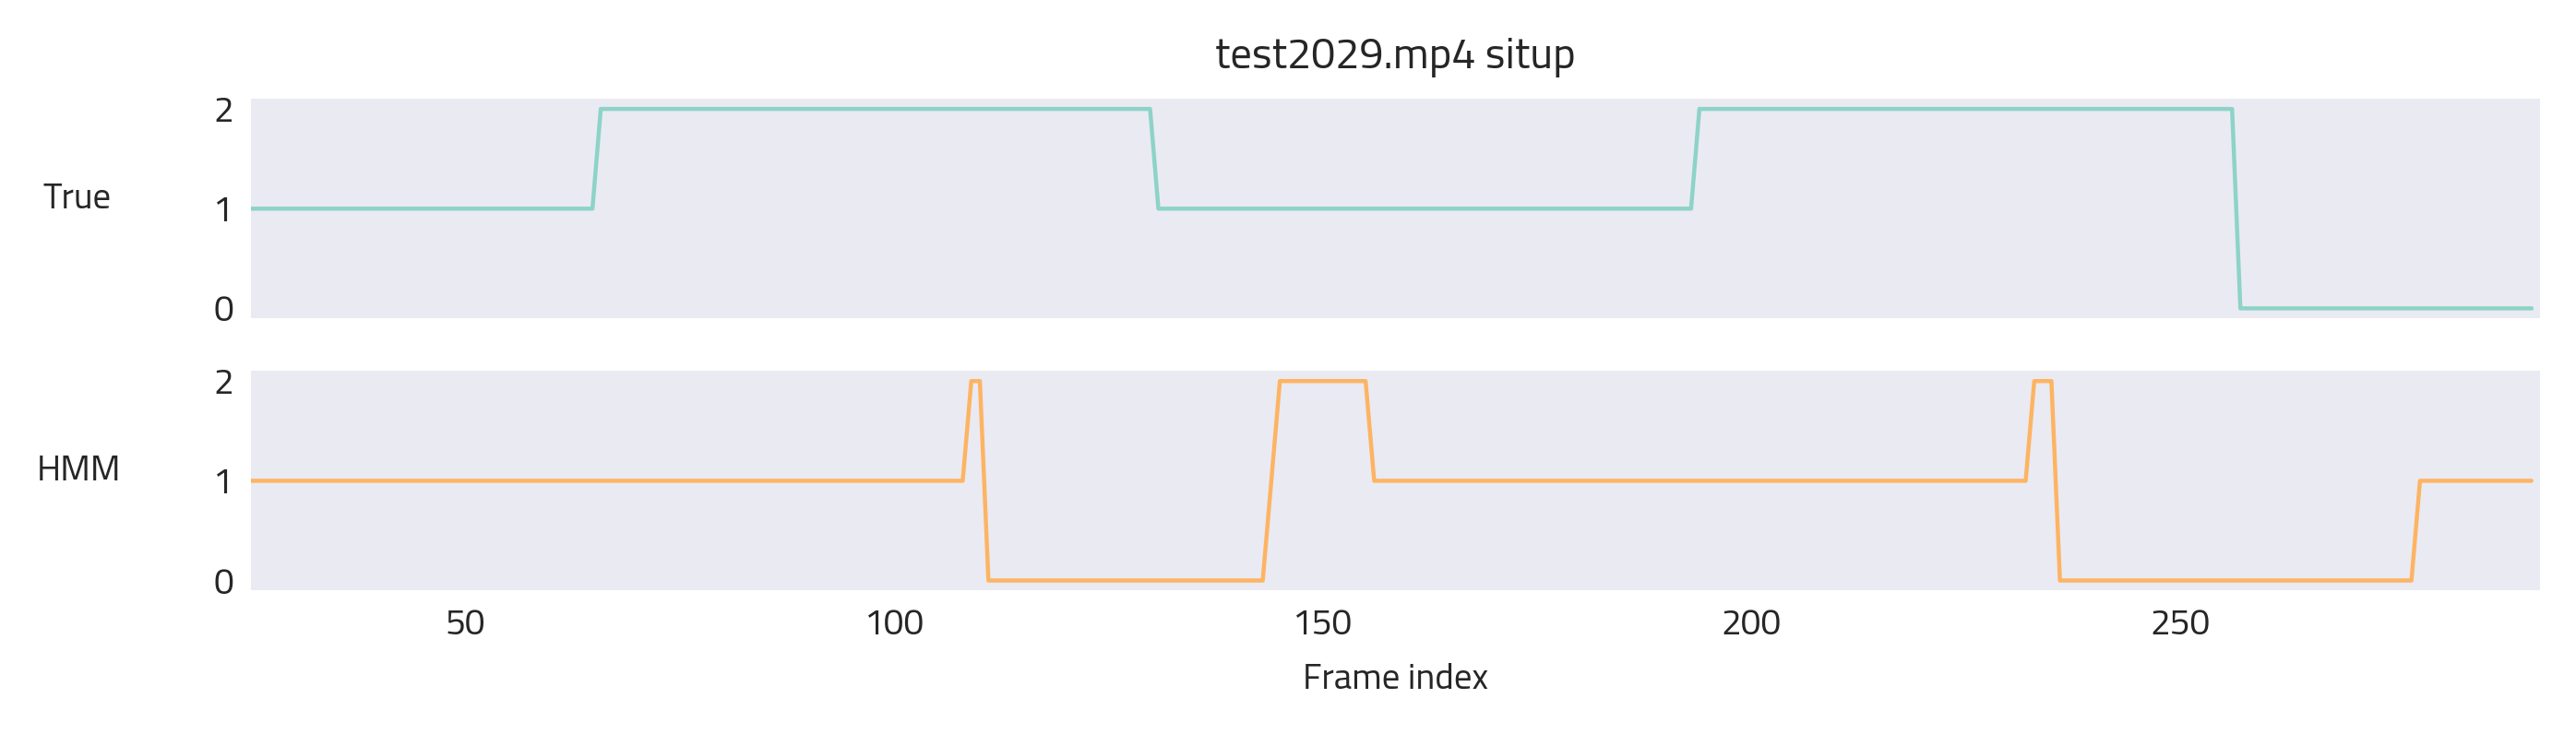

In [273]:
val_data = list(helper.get_rep_data(['val'], [action]).values())
item = random.choice(val_data)

val_x = []
js = json.load(open(osj(json_dir, template.format(item.video_name))))
for i,v in js['scores'].items():
    val_x.append(np.array(list(v.values())))
val_x = np.array(val_x)
val_y = np.array(reps_to_label(item.reps, item.total_frames, class_idx=0))
print(val_x.shape, val_y[:10])
print('startprob_', model.startprob_.shape)
pred = model.predict(val_x)
print('count', len(js['ground_truth'])//2, 'name', item.video_name, item.class_)

obo, err, acc, reps = hmm_infer(model, val_x, item.reps, 0)
print('pred count', len(reps) // 2)
print(f'obo={obo} err={err} acc={acc}')

fig, ax = plt.subplots(2, 1, figsize=(7,2), dpi=400)
ax[0].plot(val_y, 'C0', label='true')
ax[1].plot(pred, 'C5', label='HMM')
ax[0].set_yticks(range(3))
ax[0].set_xticks([])
ax[1].set_yticks(range(3))
ax[0].set_xlim(len(val_y)//12, len(val_y))
ax[1].set_xlim(len(val_y)//12, len(pred))
ax[0].text(0, 1 ,'True')
ax[1].text(0, 1 ,'HMM')
ax[0].set_title(f'{item.video_name} {item.class_}')
ax[1].set_xlabel('Frame index')
plt.tight_layout()
plt.show()

### Eval

In [215]:
def eval_subset(model, split, action):
    test_data = list(helper.get_rep_data([split], [action]).values())
    total_obo, total_err, total_acc, gt_total_count = 0, 0, 0, 0
    for item in test_data:
        test_x = []
        js = json.load(open(osj(json_dir, template.format(item.video_name))))
        for i,v in js['scores'].items():
            test_x.append(np.array(list(v.values())))
        test_x = np.array(test_x)

        pred = model.predict(test_x)
        obo, err, acc, reps = hmm_infer(model, test_x, item.reps, CLASSES.index(item.class_))
        total_obo += obo
        total_err += err
        total_acc += acc
        gt_total_count += len(item.reps) // 2

    err_rate = total_err / len(test_data)
    acc_rate = total_acc / len(test_data)
    return dict(split=split, action=action, OBO=total_obo, MAE=err_rate, 
        hmm_acc=acc_rate, avg_count=gt_total_count/len(test_data), num_videos=len(test_data))

result = []
for action in CLASSES:
    model = train(action)
    for split in ['train', 'val', 'test']:
        result.append(eval_subset(model, split, action))

df = pd.DataFrame(result)
df.to_csv('hmm_result.csv')
print(df.to_latex(index=False))

situp (88162, 1, 12) num y [0 1 2]
push_up (90438, 1, 12) num y [0 3 4]
pull_up (85193, 1, 12) num y [0 5 6]
jump_jack (57043, 1, 12) num y [0 7 8]
squat (87472, 1, 12) num y [ 0  9 10]
front_raise (54778, 1, 12) num y [ 0 11 12]
\begin{tabular}{llrrrrr}
\toprule
split &      action &  OBO &       MAE &  hmm\_acc &  avg\_count &  num\_videos \\
\midrule
train &       situp &   24 &  9.074468 & 0.374567 &  12.553191 &          94 \\
  val &       situp &    2 &  8.666667 & 0.430678 &  14.888889 &          18 \\
 test &       situp &    1 & 10.000000 & 0.422865 &  13.500000 &          20 \\
train &     push\_up &   18 & 10.724138 & 0.493815 &  19.402299 &          87 \\
  val &     push\_up &    4 &  9.055556 & 0.507021 &  13.055556 &          18 \\
 test &     push\_up &    2 &  8.750000 & 0.482024 &  18.937500 &          16 \\
train &     pull\_up &   25 &  5.627660 & 0.491427 &  10.968085 &          94 \\
  val &     pull\_up &    2 &  6.214286 & 0.573430 &  11.571429 &          14 \\

## LSTM Visualization

In [344]:
@matplotlib.rc_context(params)
def plot_pred(result: List[int],
              gt: List[int],
              orig_reps: List[int],
              total_frames: int,
              fps: float,
              title: str,
              step: int = 8,
              show: bool = True,
              save_path: str = None) -> None:
    video_len = total_frames / fps
    max_num_ticks = 10
    plt.figure(figsize=(8, 2))
    plt.xlabel('Second', fontsize=10)
    plt.yticks([])
    plt.ylim(0, 1)
    offset = total_frames // 7
    plt.xlim(-offset * 1.1, total_frames + 5)
    h = 0.2
    plt.xticks(np.linspace(0, total_frames, max_num_ticks),
               np.round(np.linspace(0.0, video_len, max_num_ticks), 2), fontsize=10)
    # background
    rect = plt.Rectangle((0, h), total_frames, 0.6, color='w')
    plt.gca().add_patch(rect)
    for i in range(0, len(gt), 2):
        rect = plt.Rectangle((gt[i], 0.6), (gt[i + 1] - gt[i]), h, color='C1')
        plt.gca().add_patch(rect)
    plt.vlines(gt, color='C0', linewidth=2, ymin=0.6, ymax=0.8)
    for j in range(0, len(result), 2):
        rect = plt.Rectangle((result[j], 0.4), (result[j + 1] - result[j]),
                             h - 0.01,
                             color='C2')
        plt.gca().add_patch(rect)
    for i in range(0, len(orig_reps), 2):
        rect = plt.Rectangle((orig_reps[i], 0.2), (orig_reps[i + 1] - orig_reps[i]),
                             h - 0.01,
                             color='C5')
        plt.gca().add_patch(rect)
    plt.title(title)
    plt.text(-offset, 0.65, 'Ground Truth', color='C0', fontsize=9)
    plt.text(-offset, 0.45, 'LSTM Prediction', color='C2', fontsize=9)
    plt.text(-offset, 0.25, 'Baseline', color='C4', fontsize=9)
    if show:
        plt.show()
    if save_path is not None:
        plt.savefig(save_path)
    plt.close()

In [336]:
from workoutdetector.datasets import RepcountHelper
from workoutdetector.utils.eval import load_json, infer
from workoutdetector.utils import pred_to_count

data_root = os.path.expanduser("~/data/RepCount")
json_dir = '../out/acc_0.841_epoch_26_20220711-191616_1x1'
metrics_df = pd.read_csv('../exp/time_series/test_metrics_1.csv', index_col=0)
print(metrics_df.head(1))
anno_path = os.path.expanduser("~/data/RepCount/annotation.csv")
helper = RepcountHelper(data_root, anno_path)
CLASSES = helper.classes
print(CLASSES)
data = helper.get_rep_data(['val', 'test'], ['all'])

                   action  split       acc  pred_count  gt_count  \
name                                                               
train951.mp4  front_raise  train  0.751295           2         4   

                       pred_reps  gt_reps  
name                                       
train951.mp4  [41, 74, 102, 132]      NaN  
['situp', 'push_up', 'pull_up', 'jump_jack', 'squat', 'front_raise']


stu6_13.mp4
gt 9 LSTM 8 Baseline 4


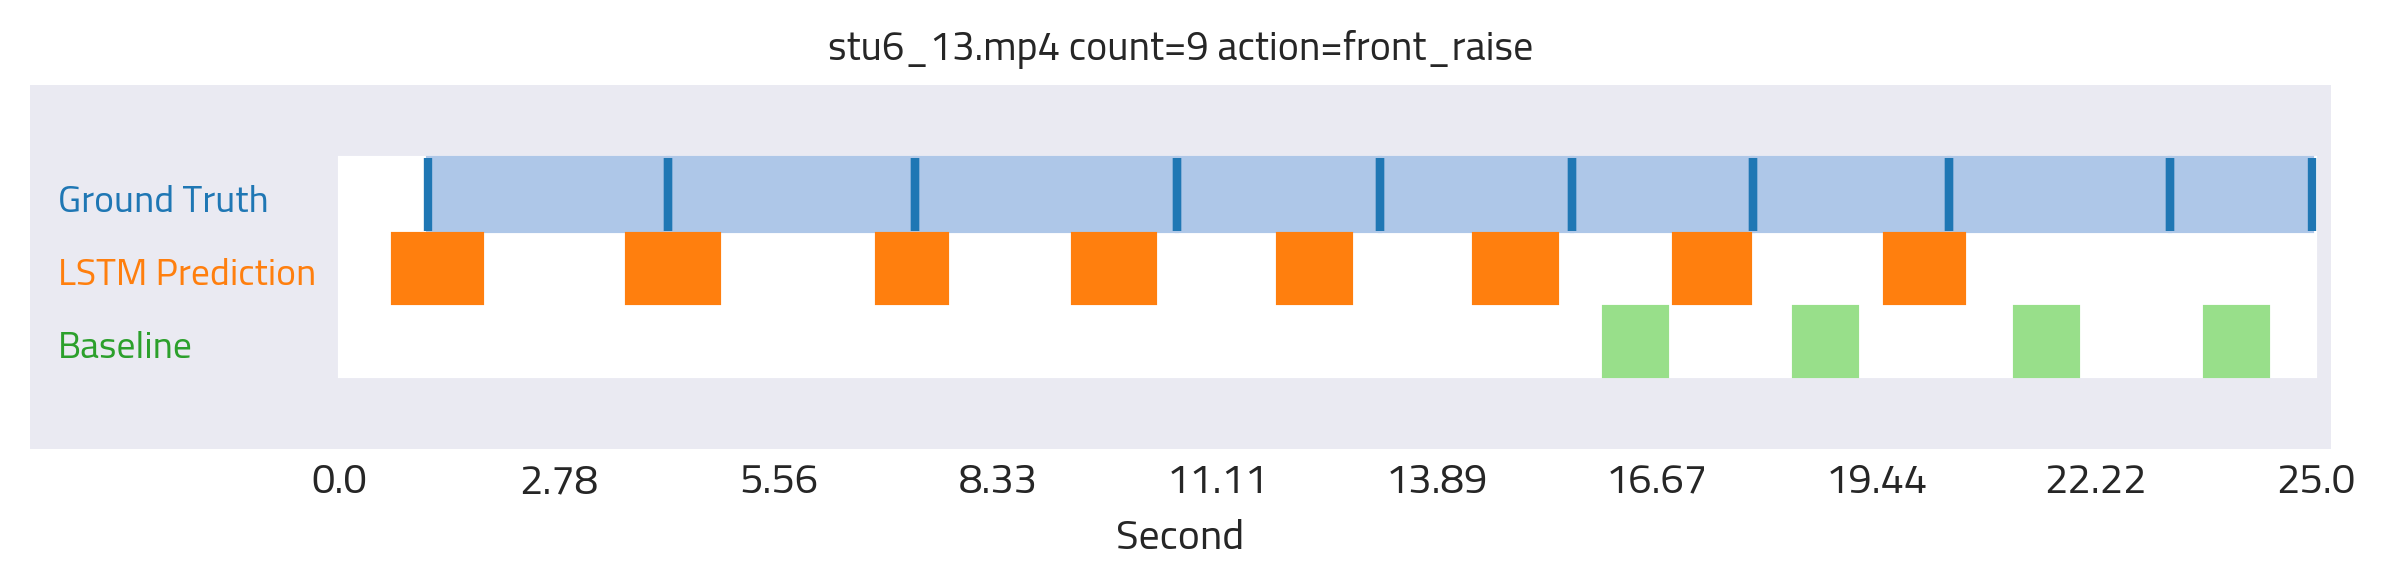

In [345]:
item = metrics_df.loc[random.choice(metrics_df[metrics_df['split'] != 'train'].index)]
json_file = f'{json_dir}/{item.name}.stride_1_step_1.json'
score, _ = load_json(json_file, softmax=True)
base_count, base_reps = pred_to_count(infer(score, 0.6, window=10), stride=1*10, step=1)
# print(orig_reps)
pred_rep = list(map(int, item.pred_reps[1:-1].split(','))) if len(item.pred_reps) > 2 else []
# print(pred_rep)
print(item.name)
print('gt', item.gt_count, 'LSTM', len(pred_rep)//2, 'Baseline', base_count)
x = data[item.name]
plot_pred(pred_rep, x.reps, base_reps, x.total_frames, x.fps, 
    title=f"{x.video_name} count={x.count} action={x.class_}", step=1)

In [346]:
def save_all_lstm_plot(csv_path: str, out_dir: str) -> None:
    os.makedirs(out_dir, exist_ok=True)
    metrics_df = pd.read_csv(csv_path)
    val_test_df = metrics_df[metrics_df['split'] != 'train']
    print(val_test_df.columns)
    for item in val_test_df.itertuples():
        json_file = f'{json_dir}/{item.name}.stride_1_step_1.json'
        score, _ = load_json(json_file, softmax=True)
        base_count, base_reps = pred_to_count(infer(score, 0.6, window=10), stride=1*10, step=1)
        # print(orig_reps)
        pred_rep = list(map(int, item.pred_reps[1:-1].split(','))) if len(item.pred_reps) > 2 else []
        # print(pred_rep)
        # print(item.name)
        # print('gt', item.gt_count, 'LSTM', len(pred_rep)//2, 'Baseline', base_count)
        x = data[item.name]
        plot_pred(pred_rep, x.reps, base_reps, x.total_frames, x.fps, 
            title=f"{x.video_name} count={x.count} action={x.class_}", step=1, show=False,
            save_path=f'{out_dir}/{item.name}.png')

save_all_lstm_plot('../exp/time_series/test_metrics_1.csv', '../out/time_series/lstm_plot')

Index(['name', 'action', 'split', 'acc', 'pred_count', 'gt_count', 'pred_reps',
       'gt_reps'],
      dtype='object')
